In [1]:
import tensorflow as tf
from utils import *
from config import *
from pytz import timezone
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from import_data import Import_EfficientNetB7_data, Import_TripletNet_train_data
from model.EfficientNetB7 import EfficientNetB7_model
from model.TripletNet import TripletNet_model
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
if MODEL_NAME == 'TripletNet':
    train_triplet_generator = Import_TripletNet_train_data(TRAIN_DATA_PATH, BATCH_SIZE, IMAGE_SIZE)
    val_triplet_generator = Import_TripletNet_train_data(VAL_DATA_PATH, BATCH_SIZE, IMAGE_SIZE)
elif MODEL_NAME == 'EfficientNetB7':
    train_generator, val_generator = Import_EfficientNetB7_data(IMAGE_SIZE, BATCH_SIZE, train_data_path=TRAIN_DATA_PATH, val_data_path=VAL_DATA_PATH).build_generators('train')

callbacks = create_callbacks(CHECKPOINT_PATH, CHECKPOINT_FILE_PATH)

In [4]:
if not os.path.exists(RESULT_FILE_PATH):
	os.makedirs(RESULT_FILE_PATH) 

start = datetime.now(timezone('Asia/Seoul'))
print(f"Train start : {start}")

if MODEL_NAME == 'TripletNet':
    if PRETRAINED_CHECKPOINT_PATH:
        print(f"Pretrained checkpoint found: {PRETRAINED_CHECKPOINT_PATH}")
    else:
        print("No pretrained checkpoint found")
    model = TripletNet_model(IMAGE_SIZE, PRETRAINED_CHECKPOINT_PATH).configure_model()
    model.summary()
    model.add_loss(triplet_loss(model.outputs[0], model.outputs[1], model.outputs[2]))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    history = model.fit(
        train_triplet_generator,
        steps_per_epoch=len(train_triplet_generator),
        validation_data=val_triplet_generator,
        validation_steps=len(val_triplet_generator),
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0
    )
elif MODEL_NAME == 'EfficientNetB7':
    model = EfficientNetB7_model(IMAGE_SIZE).configure_model()
    model.summary()
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0
    )

end = datetime.now(timezone('Asia/Seoul'))
print(f"Train end : {end}")

Train start : 2024-06-06 03:42:29.526333+09:00
Pretrained checkpoint found: C:/Users/USER/Desktop/capstone_revised\train_result\EfficientNetB7_cropped_data_224_1000_0.0003_8\checkpoint\checkpoint-006-0.475577-0.519406-0.815896-0.790661.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                   

KeyboardInterrupt: 

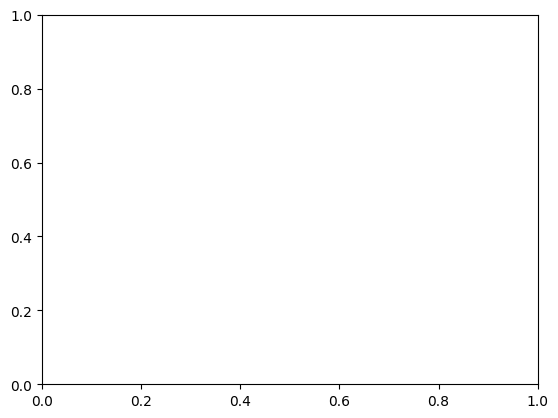

In [ ]:
save_result(history)